<a href="https://colab.research.google.com/github/daniellemosborne/CSCI166/blob/main/Osborne_CSCI166_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Traffic Intersection with Q-Learning
The objective of this project is to use Q-learning to optimize the movement of traffic through an intersection. This will involve training a reinforcement agent to learn optimal policies through state-action pair updates in a 3x3 grid representation of the intersection where four roads meet. The primary goal of optimization is to minimize the wait time for vehicles and reduce congestion by clearing queues efficiently.

The 3x3 Grid World will be represented as follows:
```
     N

   0 1 0
W  1 + 1  E
   0 1 0
     
     S
```
Details of the Grid World:
*   Queues (1):<br>
    - Represents roads with vehicles waiting to move through the intersection
    - Vehicles can come from N, S, E, and W
*   Intersection (+):<br>
    - Represents the intersection in which vehicles will pass through when the traffic light allows
    - Will be controlled by traffic signals (N-S green or E-W green)
*   Empty Cells (0):<br>
    - Represent parts of the grid where there is no road or traffic
*   Traffic Flow:<br>
    - Vehicles approach the center (+) from N, S, E, or W and exit once the signals allow

# Reward Mechanism
The reward function can be represented as follows:<br><br>
r = Total Queue Length(Previous State) - Total Queue Length (Current State)
<br><br>
- **Positive reward**: Granted when the total queue length decreases
- **Negative reward**: Applied when the total queue length increases




# Defining the environment

In [1]:
import numpy as np

class Traffic_Intersection:
    def __init__(self, grid_size=(3, 3)):
        # defining the grid world dimensions
        self.grid_size = grid_size

        # initialize queues at the N, S, E, W positions in the grid
        self.queues = {
            'N': 5,       # traffic approaching from the north
            'S': 3,       # traffic approaching from the south
            'E': 4,       # traffic approaching from the east
            'W': 6        # traffic approaching from the west
        }
        self.state = self.get_state()
        self.actions = ['NS_green', 'EW_green']  # traffic lights

    def get_state(self):
        # represent the current state as a tuple of queue lengths
        return tuple(self.queues.values())

    # visualize the grid
    def display_grid(self):
        grid = [[0] * self.grid_size[1] for _ in range(self.grid_size[0])]
        grid[0][1] = self.queues['N']   # north queue
        grid[1][0] = self.queues['W']   # west queue
        grid[1][1] = '+'                # intersection
        grid[1][2] = self.queues['E']   # east queue
        grid[2][1] = self.queues['S']   # south queue

        # print grid
        for row in grid:
            print(' '.join(str(cell) for cell in row))

    # simulate action
    def simulate_action(self, action):
        # adding random vehicle arrivals
        for direction in self.queues.keys():
          # random arrival of 0 or 1 vehicle
          self.queues[direction] += np.random.randint(0, 2)
          # cap the queue length to 10
          self.queues[direction] = min(self.queues[direction], 10)
        # update queues based on the action taken
        if action == 'NS_green':
            self.queues['N'] = max(0, self.queues['N'] - 2)
            self.queues['S'] = max(0, self.queues['S'] - 2)
        elif action == 'EW_green':
            self.queues['E'] = max(0, self.queues['E'] - 2)
            self.queues['W'] = max(0, self.queues['W'] - 2)

        # update state
        self.state = self.get_state()

    def calculate_reward(self, prev_state):
        # reward will be granted when total queue length is reduced
        prev_total_queue = sum(prev_state)                  # total vehicles in previous state
        current_total_queue = sum(self.state)               # total vehicles in current state
        max_queue_length = 40                               # max is 10 vehicles per queue
        reward = (prev_total_queue - current_total_queue) / max_queue_length
        return reward


# Implementation of Q-Learning

In [2]:
# initialize the environment
env = Traffic_Intersection()

# hyperparameters
alpha = 0.1     # learning rate
gamma = 0.9     # discount factor
epsilon = 0.1   # exploration rate
episodes = 500  # number of training episodes

# state and action space setup
state_space = [(n, s, e, w) for n in range(11) for s in range(11) for e in range(11) for w in range(11)]
state_index_map = {state: idx for idx, state in enumerate(state_space)}
state_space_size = len(state_space)
action_space_size = len(env.actions)

# initialize the Q-table
q_table = np.zeros((state_space_size, action_space_size))

# epsilon-greedy action selection
def choose_action(state_index):
    if np.random.rand() < epsilon:
        return np.random.choice(action_space_size)  # explore
    else:
        return np.argmax(q_table[state_index])      # exploit

# Q-learning update
def update_q_table(state_index, action, reward, next_state_index):
    best_next_action = np.argmax(q_table[next_state_index])
    q_table[state_index, action] += alpha * (
        reward + gamma * q_table[next_state_index, best_next_action] - q_table[state_index, action]
    )

# training loop
def train_with_hyperparameters(alpha, gamma, epsilon, episodes=1000):
    # initialize Q-table
    q_table = np.zeros((state_space_size, action_space_size))

    # track cumulative rewards
    cumulative_rewards = []

    for episode in range(episodes):
        env = Traffic_Intersection()  # reset environment for each episode
        state = env.get_state()
        state_index = state_index_map[state]

        total_reward = 0  # track rewards in this episode

        for t in range(100):  # limit steps per episode
            # epsilon-greedy action selection
            if np.random.rand() < epsilon:
                action_idx = np.random.choice(action_space_size)  # explore
            else:
                action_idx = np.argmax(q_table[state_index])      # exploit

            action = env.actions[action_idx]

            prev_state = env.state
            env.simulate_action(action)  # take the action
            next_state = env.get_state()

            # handle missing states
            if next_state not in state_index_map:
                continue

            next_state_index = state_index_map[next_state]

            reward = env.calculate_reward(prev_state)             # calculate reward
            total_reward += reward

            # Q-learning update
            best_next_action = np.argmax(q_table[next_state_index])
            q_table[state_index, action_idx] += alpha * (
                reward + gamma * q_table[next_state_index, best_next_action] - q_table[state_index, action_idx]
            )

            state_index = next_state_index  # move to the next state

        # append cumulative reward
        cumulative_rewards.append(total_reward)

    return q_table, cumulative_rewards

# hyperparameter sets to test
hyperparameter_sets = [
  {"alpha": 0.1, "gamma": 0.9, "epsilon": 0.1},
  {"alpha": 0.1, "gamma": 0.9, "epsilon": 0.2},
  {"alpha": 0.1, "gamma": 0.9, "epsilon": 0.3},
  {"alpha": 0.5, "gamma": 0.9, "epsilon": 0.1},
  {"alpha": 0.5, "gamma": 0.9, "epsilon": 0.3},
]

# train and record results for each hyperparameter set
results = {}
for params in hyperparameter_sets:
    print(f"\nTraining with alpha={params['alpha']}, gamma={params['gamma']}, epsilon={params['epsilon']}")
    q_table, cumulative_rewards = train_with_hyperparameters(**params)
    results[f"alpha={params['alpha']}, epsilon={params['epsilon']}"] = cumulative_rewards

    # print cumulative rewards
    print(f"Cumulative rewards for alpha={params['alpha']}, epsilon={params['epsilon']}: {sum(cumulative_rewards)}")


Training with alpha=0.1, gamma=0.9, epsilon=0.1
Cumulative rewards for alpha=0.1, epsilon=0.1: 421.92500000000024

Training with alpha=0.1, gamma=0.9, epsilon=0.2
Cumulative rewards for alpha=0.1, epsilon=0.2: 420.37500000000017

Training with alpha=0.1, gamma=0.9, epsilon=0.3
Cumulative rewards for alpha=0.1, epsilon=0.3: 418.19999999999965

Training with alpha=0.5, gamma=0.9, epsilon=0.1
Cumulative rewards for alpha=0.5, epsilon=0.1: 423.40000000000026

Training with alpha=0.5, gamma=0.9, epsilon=0.3
Cumulative rewards for alpha=0.5, epsilon=0.3: 417.1749999999999


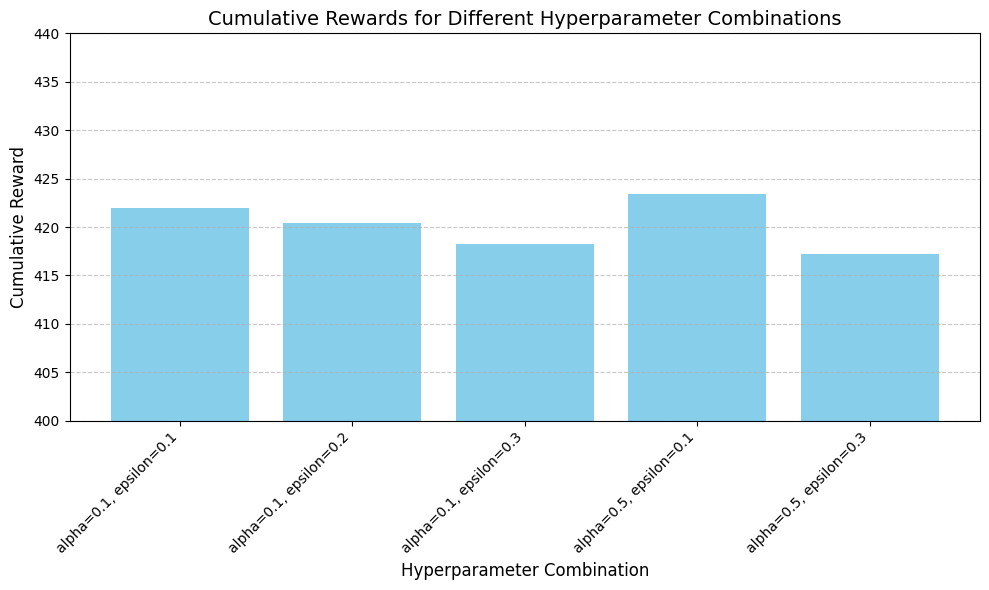

In [3]:
import matplotlib.pyplot as plt

# results from training
hyperparameter_sets = [
    {"alpha": 0.1, "gamma": 0.9, "epsilon": 0.1, "cumulative_reward": 421.925},
    {"alpha": 0.1, "gamma": 0.9, "epsilon": 0.2, "cumulative_reward": 420.375},
    {"alpha": 0.1, "gamma": 0.9, "epsilon": 0.3, "cumulative_reward": 418.199},
    {"alpha": 0.5, "gamma": 0.9, "epsilon": 0.1, "cumulative_reward": 423.400},
    {"alpha": 0.5, "gamma": 0.9, "epsilon": 0.3, "cumulative_reward": 417.174},
]

# get hyperparameter labels and cumulative rewards
labels = [f"alpha={hp['alpha']}, epsilon={hp['epsilon']}" for hp in hyperparameter_sets]
cumulative_rewards = [hp['cumulative_reward'] for hp in hyperparameter_sets]

# creating bar chart
plt.figure(figsize=(10, 6))
plt.bar(labels, cumulative_rewards, color='skyblue')

plt.title("Cumulative Rewards for Different Hyperparameter Combinations", fontsize=14)
plt.xlabel("Hyperparameter Combination", fontsize=12)
plt.ylabel("Cumulative Reward", fontsize=12)

plt.ylim(400, 440)

plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()



Testing the learned policy
Step 1: Action: EW_green
0 6 0
4 + 3
0 4 0
Total Queue: 17

Step 2: Action: EW_green
0 6 0
2 + 2
0 4 0
Total Queue: 14

Step 3: Action: NS_green
0 4 0
3 + 3
0 2 0
Total Queue: 12

Step 4: Action: NS_green
0 3 0
3 + 3
0 1 0
Total Queue: 10

Step 5: Action: NS_green
0 2 0
4 + 4
0 0 0
Total Queue: 10

Step 6: Action: EW_green
0 3 0
3 + 3
0 1 0
Total Queue: 10

Step 7: Action: NS_green
0 1 0
3 + 3
0 0 0
Total Queue: 7

Step 8: Action: NS_green
0 0 0
3 + 4
0 0 0
Total Queue: 7

Step 9: Action: EW_green
0 1 0
1 + 3
0 1 0
Total Queue: 6

Step 10: Action: NS_green
0 0 0
1 + 3
0 0 0
Total Queue: 4

Step 11: Action: EW_green
0 0 0
0 + 1
0 0 0
Total Queue: 1

Step 12: Action: EW_green
0 1 0
0 + 0
0 0 0
Total Queue: 1

Step 13: Action: NS_green
0 0 0
1 + 0
0 0 0
Total Queue: 1

Step 14: Action: EW_green
0 1 0
0 + 0
0 1 0
Total Queue: 2

Step 15: Action: NS_green
0 0 0
1 + 1
0 0 0
Total Queue: 2

Step 16: Action: EW_green
0 0 0
0 + 0
0 1 0
Total Queue: 1

Step 17: Action

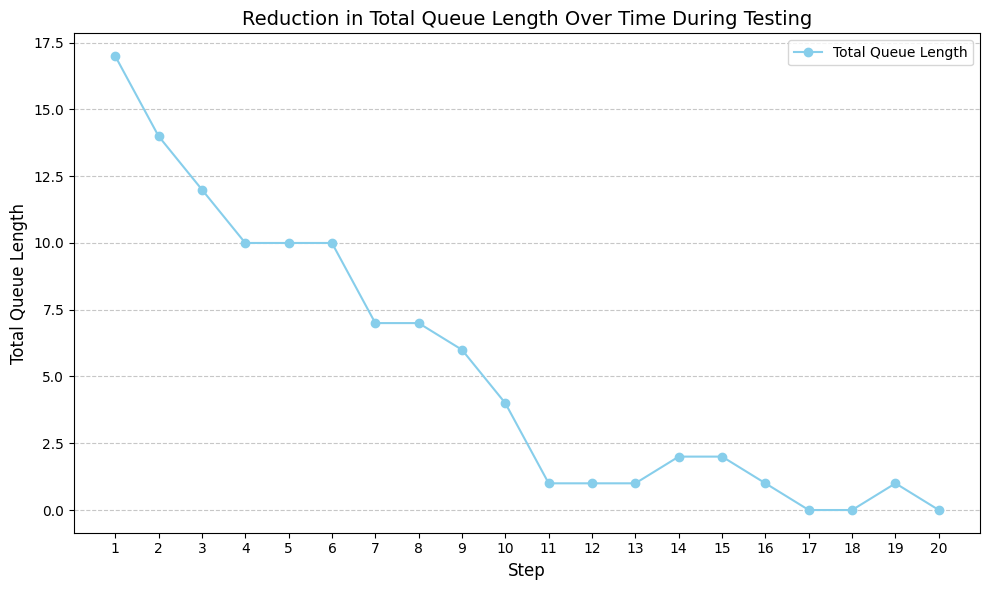

In [5]:
import matplotlib.pyplot as plt

# testing the learned policy and tracking queue length reduction
print("\nTesting the learned policy")
env = Traffic_Intersection()
state = env.get_state()
state_index = state_index_map[state]

# list to store total queue lengths over time
queue_lengths = []

for t in range(20):  # limit steps during testing
    action_idx = np.argmax(q_table[state_index])  # choose the best action
    action = env.actions[action_idx]
    print(f"Step {t+1}: Action: {action}")
    env.simulate_action(action)
    env.display_grid()
    total_queue = sum(env.state)
    queue_lengths.append(total_queue)  # track total queue length
    print(f"Total Queue: {total_queue}\n")
    state = env.get_state()
    state_index = state_index_map[state]

# plot the reduction in queue length over time
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(queue_lengths) + 1), queue_lengths, marker='o', color='skyblue', label="Total Queue Length")

plt.title("Reduction in Total Queue Length Over Time During Testing", fontsize=14)
plt.xlabel("Step", fontsize=12)
plt.ylabel("Total Queue Length", fontsize=12)
plt.xticks(range(1, len(queue_lengths) + 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

plt.tight_layout()
plt.show()
